# Parallelized Cubic Spline Interpolation

A part of the Fast EMRI waveforms package is parallelized cubic spline interpolation. This generally means fitting and evaluating many splines in parallel with the same input x array. This is available for GPUs and CPUs (not parallelized for CPU). The user can perform this operation entirely in Python while leveraging [CuPy](https://cupy.dev/) for GPUs. However, the evaluation will not be as efficient as when it is implemented properly in a customized kernel. The spline class ([CubicSplineInterpolant](https://bhptoolkit.org/FastEMRIWaveforms/user/sum.html#few.summation.interpolatedmodesum.CubicSplineInterpolant)) can provide an 1D flattened array of all spline coefficients for use in a custom CUDA kernel. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import few

# tune few configuration
cfg_set = few.get_config_setter(reset=True)

# Uncomment if you want to force CPU or GPU usage
# Leave commented to let FEW automatically select the best available hardware
#   - To force CPU usage:
# cfg_set.enable_backends("cpu")
#   - To force GPU usage with CUDA 12.x
# cfg_set.enable_backends("cuda12x", "cpu")
#   - To force GPU usage with CUDA 11.x
# cfg_set.enable_backends("cuda11x", "cpu")

cfg_set.set_log_level("info");

In [3]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux
from few.amplitude.romannet import RomanAmplitude

traj = EMRIInspiral(func=SchwarzEccFlux)
amp = RomanAmplitude()

# parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7
theta = np.pi / 3.0
phi = np.pi / 2.0

# get trajectory
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0)
# Schwarzschild
a = 0.0

teuk_modes = amp(a, p, e, x)

In [4]:
from few.summation.interpolatedmodesum import CubicSplineInterpolant

# let's take the amplitudes from the last step and spline those.
# We have to arange everything in the shape (ninterps, length)
# We will split real and imaginary components

interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))

interp_in[: teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1] :, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

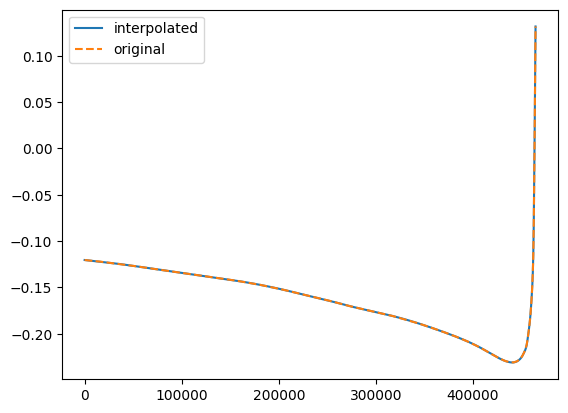

In [11]:
# get new values
t_new = np.linspace(t[0], t[-1], 1000)

# notice the new shape is (ninterps, length) just like the inital input to the spline
new_teuk_modes = spline(t_new)

# (220) mode (real part)
ind = amp.special_index_map[(2, 2, 0)]

plt.plot(t_new, new_teuk_modes[ind], label="interpolated")
plt.plot(t, teuk_modes[:, ind].real, "--", label="original")
plt.legend()
plt.show()

To get the array of interp coefficients for CUDA implementations, do the following. The underlying shape of the array is (4, length, ninterps). It is flattened though for entry into GPU kernel. 

In [21]:
spline.interp_array

array([ 6.23856751e-06,  3.56609646e-06, -1.26237401e-06, ...,
       -4.68897885e-11, -6.21556174e-11, -2.72473618e-11])

For convenience, the coefficients array can be returned to its original form via the `reshape_shape` attribute:


In [27]:
spline.interp_array.reshape(spline.reshape_shape).shape

(4, 51, 7686)